# Beyond Churn Prediction and Churn Uplift

A very common task in data science is *churn prediction*. However, predicting churn is often just an intermediate step and rarely the final objective. Usually, what we actually care about is **reducing churn**, which is a separate objective, not necessarily related. In fact, for example, knowing that long-term customers are less likely to churn than new customers is not an actionable insight since we cannot increase customers' tenure. What we would like to know instead is how one (or more) treatment impacts churn. This is often referred to as **churn uplift**.

In this article, we will be going **beyond** both churn prediction and churn uplift and consider instead the ultimate goal of churn-prevention campaigns: **increasing revenue**. First of all, a policy that reduces churn might also have an impact on revenue, which should be taken into account. However, and more importantly, increasing revenue is relevant only if the customer does not churn. Vice-versa, decreasing churn is more relevant for high-revenue customers. This **interaction** between churn and revenue is critical in understanding the profitability of any treatment campaign and should not be overlooked.

## Gifts and Subscriptions

For the rest of the article, we are going to use a **toy example** to illustrate the main idea. Suppose we were a company interested in reducing our customer's churn and ultimately increasing our revenue. Suppose we have decided to test a new idea: sending a **gift** of *1\\$* to our users. In order to test whether the treatment works, we have randomly sent it only to a subsample of our customer base. 

In [1]:
cost = 1

Let’s have a look at the data we have at our disposal. I import the data-generating process `dgp_gift()` from `src.dgp`. I also import some plotting functions and libraries from `src.utils`. 

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
from src.utils import *
from src.dgp import DGP

In [4]:
class dgp_gift(DGP):
    """DGP: gift"""
    X: list[str] = ['age', 'rev_old', 'rev_change']
    D: str = 'gift'
    Y: list[str] = ['churn', 'revenue']

    def generate_baseline(self, seed:int = 0):
        np.random.seed(seed)
        months = np.random.exponential(5, self.n)
        rev_old = np.maximum(0, np.random.exponential(7, self.n) - 2)
        rev_change = np.random.normal(0, 2, self.n)
        churn_c = np.random.beta(1 - rev_change*(rev_change<0), 2 + rev_old) > 0.4
        rev_c = 0.8*rev_old + 0.2*np.maximum(0, np.random.exponential(7, self.n) - 2)
        df = pd.DataFrame({'months': months, 'rev_old': rev_old, 'rev_change': rev_change,
                           'churn_c': churn_c, 'revenue_c': rev_c})
        return df

    def add_treatment_effect(self, df, seed:int = 1):
        np.random.seed(seed)
        effect_c = - np.random.binomial(1, 0.3, self.n) * (df.months<7)
        df['effect_on_churn'] = effect_c * (df.churn_c==1)
        effect_r = np.random.normal(0.9, 0.5, self.n)* (df.months>3)
        df['effect_on_revenue'] = np.maximum(-df.revenue_c, effect_r)
        return df

    def add_assignment(self, df: pd.DataFrame, seed: int = 2) -> pd.DataFrame:
        np.random.seed(seed)
        df[self.D] = np.random.binomial(1, 0.5, self.n)
        return df

    def add_post_treatment_variables(self, df : pd.DataFrame, seed: int = 0) -> pd.DataFrame:
        df.revenue *= (1-df.churn)
        return df

In [5]:
dgp = dgp_gift(n=100_000)
df = dgp.generate_data()
df.head()

,months,rev_old,rev_change,gift,churn,revenue
0,3.98,3.36,0.86,0,0,7.28
1,6.28,14.41,-2.77,1,0,11.60
2,4.62,2.89,-2.21,0,0,3.59
3,3.94,0.00,-3.26,0,1,0.00
4,2.76,3.25,-3.43,0,0,5.33


We have information on `100_000` customers for which we observe the number of `months` they have been active customers, the revenue they generated in the last month (`rev_old`), the change in revenue between the last month and the previous one (`rev_change`), whether they were randomly sent a `gift` and the two outcomes of interest: `churn`, i.e. whether they are not active customers anymore and the `revenue` they have generated in the current month. We denote the outcomes with the letter *Y*, the treatment with the letter *W* and the other variables with the letter *X*.

In [6]:
Y = ['churn', 'revenue']
W = 'gift'
X = ['months', 'rev_old', 'rev_change']

**Note** that, for simplicity, we are considering a single-period snapshot of the data and summarizing the panel structure of the data in just a couple of variables. Usually we would have a longer time series but also a longer time horizon for what concerns the outcome (e.g. [customer lifetime value](https://en.wikipedia.org/wiki/Customer_lifetime_value)).

We can represent the underlying data generating process with the following **Directed Acyclic Graph (DAG)**. Nodes represent variables and arrows represent potential causal relationships. I have highlighted in green the two relationships of interest: the effect of the `gift` on `churn` and `revenue`. Note that `churn` is related to revenue since churned customers by definition generate zero revenue.

```mermaid
flowchart TD
classDef included fill:#DCDCDC,stroke:#000000,stroke-width:3px;
classDef empty width:-10px,height:-10px,fill:#000000,stroke-width:0px;

W((1$ gift))
D1(( ))
D2(( ))
Y1((churn))
Y2((revenue))
X1((months))
X2((revenue change))
X3((revenue old))

W --- D1
X1 --- D1
D1 --> Y1
W --- D2
X1 --- D2
D2 --> Y2
Y1 --> Y2
X2 --> Y1
X3 --> Y1
X3 --> Y2

class W,Y1,Y2,X1,X2,X3 included;
class D1,D2 empty;

linkStyle 0,2,3,5 stroke:#2db88b,stroke-width:6px;
linkStyle 1,4,6,7,8,9 stroke:#003f5c,stroke-width:6px;
```

Importantly, past revenue and the revenue change are predictors of `churn` and `revenue` but are not related to our intervention. On the contrary, the intervention affects `churn` and `revenue` differentially depending on the customers total active `months`.

While simplistic, this data generating process aims at captiring an important **insight**: variables that are good predictors of `churn` or `revenue`, are not necessarily variables that predict `churn` or `revenue` **lift**. We will see later how this impacts our analysis. 

Let's start first by exploring the data.

## Exploratory Data Analysis

Let's start with `churn`. How many customers did the company lose last month?

In [7]:
df.churn.mean()

0.19767

The company lost almost *20\%* of customers last month! Did the `gift` help in preventing churn?

We want to compare the churn frequency of customers that received the gift with the churn frequency of customers that did not receive the gift. Since the gift was randomized, the difference-in-means estimator is an unbiased estimator for the [average treatment effect (ATE)](https://en.wikipedia.org/wiki/Average_treatment_effect) of the `gift` on `churn`.

$$
ATE = \mathbb{E} \Big[ Y \ \Big| \ W = 1 \Big] - \mathbb{E} \Big[ Y \ \Big| \ W = 0 \Big]
$$

We compute the difference-in-means estimate by linear regression. We also include other covariates to improve the efficiency of the estimator.

In [8]:
smf.ols("churn ~ " + W + " + " + " + ".join(X), data=df).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.3271,0.002,151.440,0.000,0.323,0.331
gift,-0.1173,0.002,-51.521,0.000,-0.122,-0.113
months,0.0050,0.000,21.832,0.000,0.005,0.005
rev_old,-0.0181,0.000,-108.061,0.000,-0.018,-0.018
rev_change,-0.0497,0.001,-87.412,0.000,-0.051,-0.049


It looks like the `gift` decreased churn by around *11* percentage points, i.e. almost one-third of the baseline level of *32%*! Did it also have an impact on `revenue`?

As for churn, we regress `revenue` on `gift`, our treatment variable, to estimate the average treatment effect.

In [9]:
smf.ols("revenue ~ " + W + " + " + " + ".join(X), data=df).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.3691,0.010,37.910,0.000,0.350,0.388
gift,0.6317,0.010,61.560,0.000,0.612,0.652
months,0.0120,0.001,11.768,0.000,0.010,0.014
rev_old,0.8251,0.001,1092.846,0.000,0.824,0.827
rev_change,0.1457,0.003,56.777,0.000,0.141,0.151


It looks like the `gift` on average increased revenue by *0.63\\$*, which means that it was **not profitable**. Does it mean that we should stop sending gifts to our customers? It depends. In fact, the gift might be effective for certain customer segments. We just need to identify them.

## Targeting Policies

In this section, we will try to understand if there is a data-informed way to send the `gift` to customers that is profitable. In particular, we will c**compare** different data-informed targeting **policies** with the objective of increasing revenue. 

Throughout this section, we will need some algorithms to either predict `revenue`, or `churn`, or the probability of receiving the `gift`. We use gradient-boosted tree models from the [`lightgbm`](https://lightgbm.readthedocs.io/en/latest/index.html) library  We use the same models for all policies, so that we cannot attribute differences in performance to prediction accuracy.

In [10]:
from lightgbm import LGBMClassifier, LGBMRegressor

To **evaluate** each policy denoted with *τ*, we compare its profits with the policy *Π⁽¹⁾*, with its profits without the policy *Π⁽⁰⁾*, over every single individual, in a separate validation dataset. Note that this is usually not possible, since, for each customer, we only observe one of the two **potential outcomes**, with or without the `gift`. However, this is synthetic data, so we can do oracle evaluation. If you want to know more about how to evaluate uplift models with real data, I wrote an article about it.

https://towardsdatascience.com/8a078996a113

First of all, let's define profits *Π* as the net revenue *R* when the customer does not churn *C*.
$$
\Pi = R (1-C)
$$

Therefore, the overall effect on profits for treated individuals is given by the difference between the profits when treated *Π⁽¹⁾* minus the profits when not treated *Π⁽⁰⁾*.

$$
\tau_{\pi} = R_1 (1 - C_1) - R_0 (1 - C_0)
$$

The effect for untreated individuals is zero.

In [11]:
def evaluate_policy(policy):
    data = dgp.generate_data(seed_data=4, seed_assignment=5, keep_po=True)
    data['profits'] = (1 - data.churn) * data.revenue
    baseline = (1-data.churn_c) * data.revenue_c
    effect = policy(data) * (1-data.churn_t) * (data.revenue_t-cost) + (1-policy(data)) * (1-data.churn_c) * data.revenue_c
    return np.sum(effect - baseline)

### 1. Target Churning Customers

A first policy could be to just target **churning customers**. Let's say, we send the `gift` only to customers with above-average redicted churn. 

In [12]:
model_churn = LGBMClassifier().fit(X=df[X], y=df['churn'])

policy_churn = lambda df : (model_churn.predict_proba(df[X])[:,1] > df.churn.mean())
evaluate_policy(policy_churn)

-5497.46

The policy is not profitable and would lead to an aggregate **loss** of more than *5000\\$*. 

You might think that the problem is the **arbitrary threshold**, but this is not the case. Below I plot the aggregate effect for all possible policy thresholds.

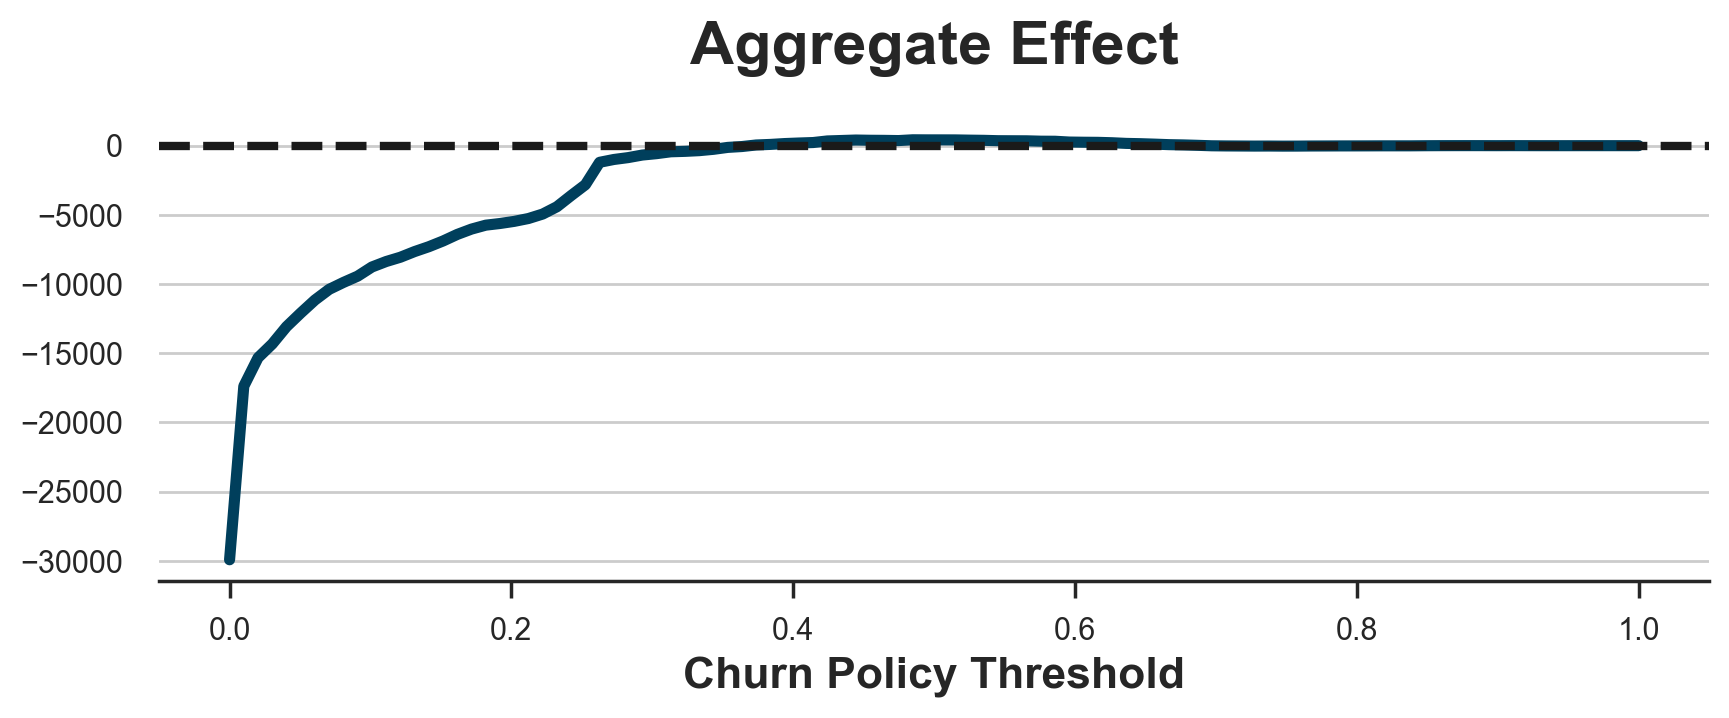

In [13]:
x = np.linspace(0, 1, 100)
y = [evaluate_policy(lambda df : (model_churn.predict_proba(df[X])[:,1] > k)) for k in x]

fig, ax = plt.subplots(figsize=(10, 3))
sns.lineplot(x=x, y=y).set(xlabel='Churn Policy Threshold', title='Aggregate Effect');
ax.axhline(y=0, c='k', lw=3, ls='--');

As we can see, at best we can make zero losses when we decide not to give the gift to any customer.

The problem is that the fact that a customer is likely to churn does not imply that the `gift` will have any impact on their churn probability. The two measures are not completely unrelated (e.g. we cannot decrease the churning probability of customers that have 0% probability of churning), but they are not the same thing.

### 2. Target revenue customers

Let's now try a different policy: we send the gift only to **high-revenue customers**. For example, we might send the gift only to the top-10% of customers by revenue. The idea is that, if the policy indeed decreases churn, these are the customers for whom decreasing churn is more profitable.

In [14]:
model_revenue = LGBMRegressor().fit(X=df[X], y=df['revenue'])

policy_revenue = lambda df : (model_revenue.predict(df[X]) > np.quantile(df.revenue, 0.9))
evaluate_policy(policy_revenue)

-4730.8200000000015

The policy is again unprofitable, leading to substantial **losses**. As before, this is not a problem of selecting the threshold as we can see in the plot below. The best we can do is set a threshold so high that we do not treat anyone and we make zero profits.

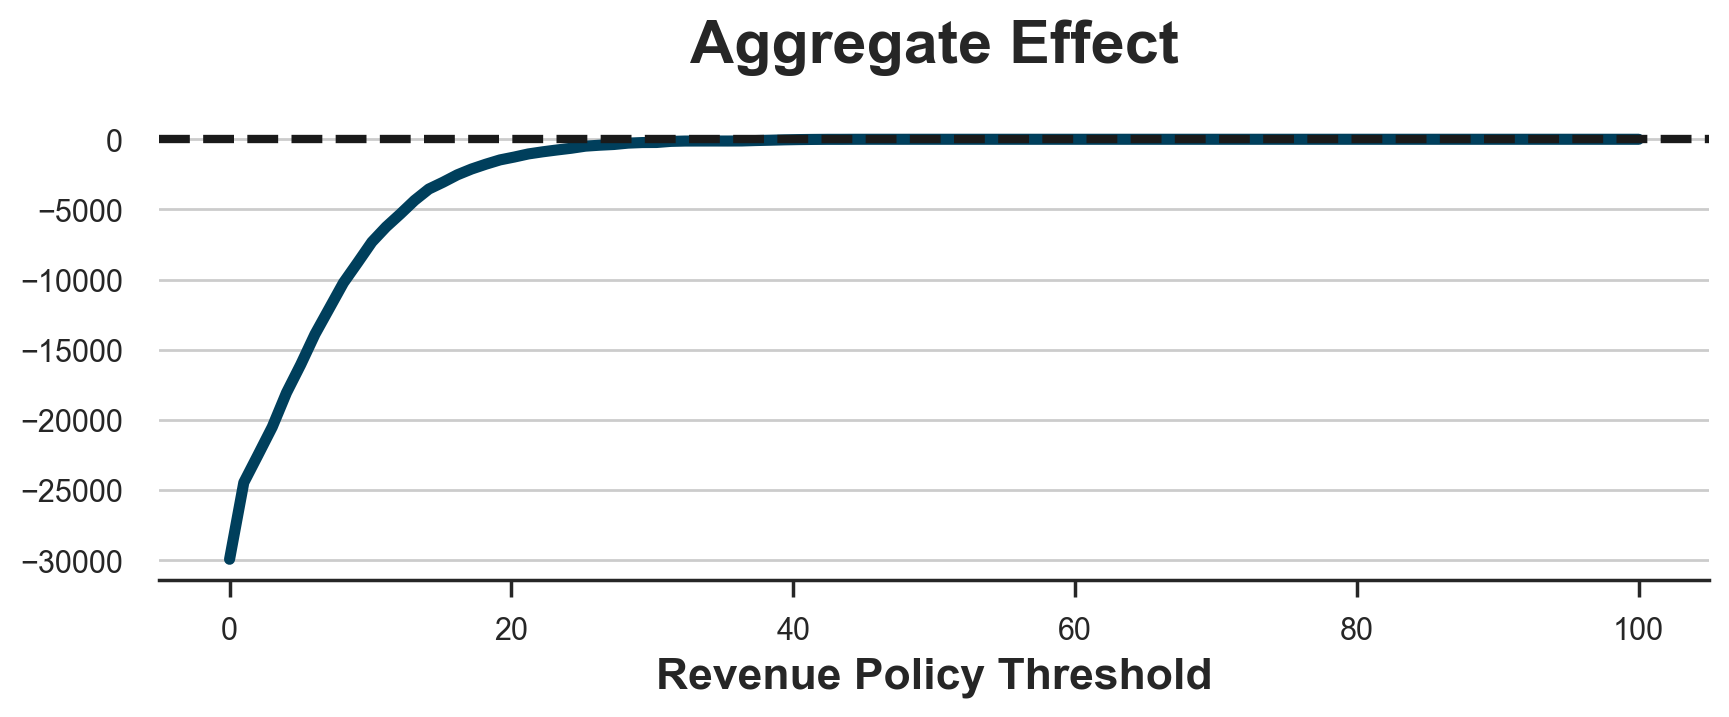

In [15]:
x = np.linspace(0, 100, 100)
y = [evaluate_policy(lambda df : (model_revenue.predict(df[X]) > k*cost)) for k in x]

fig, ax = plt.subplots(figsize=(10, 3))
sns.lineplot(x=x, y=y).set(xlabel='Revenue Policy Threshold', title='Aggregate Effect');
ax.axhline(y=0, c='k', lw=3, ls='--');

The problem is that, in our setting, the churn probability of high-revenue customers does not decrease enough to make the `gift` profitable. This is also partially due to the fact, often observed in reality, that high-revenue customers are also the least likely to churn, to begin with.

Let's now consider a more relevant set of policies: policies based on **uplift**.

### 3. Target churn uplift customers

A more sensible approach would be to target customers whose `churn` probability decreases the most when receiving the *1\\$* `gift`. We estimate churn uplift using the [double-robust estimator](https://arxiv.org/abs/2004.14497), one of the best performing uplift models. If you are unfamiliar with meta-learners, I recommend starting from my introductory article.

https://towardsdatascience.com/8a9c1e340832

We import the doubly-robust learner from [econml](https://econml.azurewebsites.net/), a Microsoft library.

In [16]:
from econml.dr import DRLearner

DR_learner_churn = DRLearner(model_regression=LGBMRegressor(), model_propensity=LGBMClassifier(), model_final=LGBMRegressor())
DR_learner_churn.fit(df['churn'], df[W], X=df[X]);

Now that we have estimated churn uplift, we might be tempted to just target customers with a high negative uplift (negative, since we want to *decrease* churn). For example, we might send the `gift` to all customers with an estimated uplift larger than the average churn.

In [17]:
policy_churn_lift = lambda df : DR_learner_churn.effect(df[X]) < - np.mean(df.churn)
evaluate_policy(policy_churn_lift)

-3925.2400000000002

The policy is still unprofitable, leading to almost *4000\\$* in losses.

The problem is that we haven't considered the cost of the policy. In fact, decreasing the churn probability is **only profitable for high-revenue customers**. Take the extreme case: avoiding churn of a customer that does not generate any revenue is not worth any intervention.

Therefore, let's only send the `gift` to customers whose churn probability weighted by revenue decreases more than the cost of the gift.

In [18]:
model_revenue_1 = LGBMRegressor().fit(X=df.loc[df[W] == 1, X], y=df.loc[df[W] == 1, 'revenue'])

policy_churn_lift = lambda df : - DR_learner_churn.effect(df[X]) * model_revenue_1.predict(df[X]) > cost
evaluate_policy(policy_churn_lift)

318.03000000000003

This policy is finally profitable!

However, we still have not considered one channel: the intervention might also affect the revenue of existing customers. 

### 4. Target revenue uplift customers

A symmetric approach to the previous one would be to consider only the impact on `revenue`, ignoring the impact on churn. We could estimate the `revenue` uplift for non-churning customers and treat only customers whose incremental effect on revenue, net of churn, is greater than the cost of the `gift`.

In [19]:
DR_learner_netrevenue = DRLearner(model_regression=LGBMRegressor(), model_propensity=LGBMClassifier(), model_final=LGBMRegressor())
DR_learner_netrevenue.fit(df.loc[df.churn==0, 'revenue'], df.loc[df.churn==0, W], X=df.loc[df.churn==0, X]);
model_churn_1 = LGBMClassifier().fit(X=df.loc[df[W] == 1, X], y=df.loc[df[W] == 1, 'churn'])

policy_netrevenue_lift = lambda df : DR_learner_netrevenue.effect(df[X]) * (1-model_churn_1.predict(df[X])) > cost
evaluate_policy(policy_netrevenue_lift)

50.800000000000004

This policy is profitable as well, but ignores the effect on churn. How do we combine this poilcy with the previous one?

### 5. Target revenue uplift customers

The best way to efficiently **combine** both the effect on churn and the effect on net revenue, is simply to estimate **total revenue uplift**. The implied optimal policy is to treat customers whose total revenue uplift is greater than the cost of the `gift`.

In [20]:
DR_learner_revenue = DRLearner(model_regression=LGBMRegressor(), model_propensity=LGBMClassifier(), model_final=LGBMRegressor())
DR_learner_revenue.fit(df['revenue'], df[W], X=df[X]);

policy_revenue_lift = lambda df : (DR_learner_revenue.effect(df[X]) > cost)
evaluate_policy(policy_revenue_lift)

2028.2100000000003

It looks like this is by far the best policy, generating an aggregate profit of more than *2000\\$*!

The result is starking if we compare all the different policies.

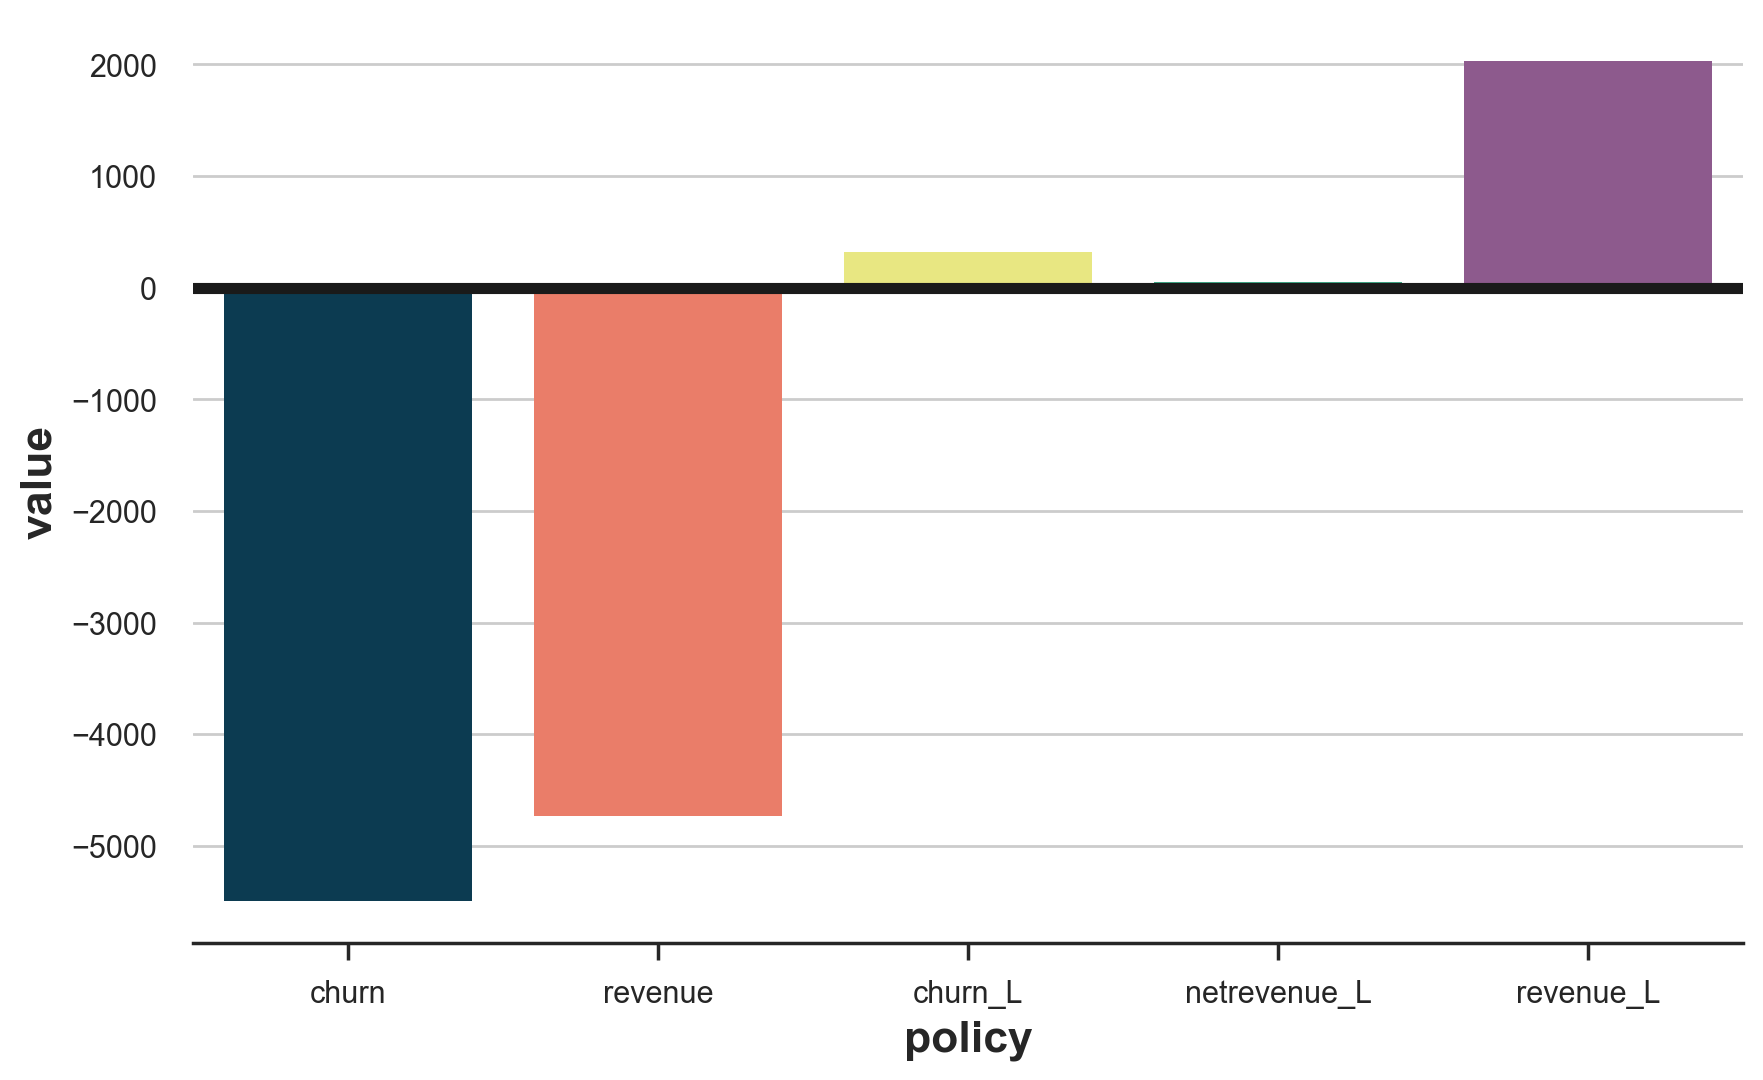

In [21]:
policies = [policy_churn, policy_revenue, policy_churn_lift, policy_netrevenue_lift, policy_revenue_lift] 
df_results = pd.DataFrame()
df_results['policy'] = ['churn', 'revenue', 'churn_L', 'netrevenue_L', 'revenue_L']
df_results['value'] = [evaluate_policy(policy) for policy in policies]

fig, ax = plt.subplots()
sns.barplot(df_results, x='policy', y='value')
plt.axhline(0, c='k');

## Intuition and Decomposition

If we compare the different policies, it is clear that targeting high-revenue or high-churn probability customers directly were the **worst choices**. This is not necessarily always the case, but it happened in our simulated data because of two facts that are also common in many real scenarios:

1. Revenue and churn probability are negatively correlated
2. The effect of the `gift` on `churn` (or `revenue`) was not strongly negatively (or positively for `revenue`) correlated with the baseline values

Either one of these two facts can be enough to make targeting revenue or churn a bad strategy. What one should target instead is customers with a high **incremental** effect. And it's best to directly use as outcome the variable of interest, `revenue` in this case, whenever available. 

To better understand the mechanism, we can **decompose** the aggregate effect of a policy on profits into three parts.

$$
\begin{aligned}
\tau_{\pi} &= R_1 * (1 - C_1) - R_0 * (1 - C_0) = \newline
&= R_1 * (1 - C_1) - \underbrace{\hat{r}_1 * (1 - \hat{c}_0) + R_1 * (1 - C_0)}_{\text{add and subtract}} - R_0 * (1 - C_0) = \newline
&= - R_1 * \tau_c + R_1 * (1 - C_0) - R_0 * (1 - C_0) = \newline
&= - R_1 * \tau_c + \tau_r * (1 - C_0) = \newline
&= \underbrace{- R_0 * \tau_c}_{\text{incremental effect on churn}} + \underbrace{\tau_r * (1 - C_0)}_{\text{incremental effect on revenue}} + \underbrace{\tau_r * \tau_c}_{\text{interaction effect}}
\end{aligned}
$$

This implies that there are **three channels** that make treating a customer profitable.

1. If it's a *high-revenue* customer and the treatment *decreases* its churn probability
2. If it's a *non-churning* customer and the treatment *increases* its revenue
3. It the treatment has a strong impact on *both* its revenue and churn probability

Targeting by churn uplift exploits only the first channel, targeting by net revenue uplift exploits only the second channel, and targeting by total revenue uplift exploits all three channels, making it the **most effective** method.

### Bonus: weighting

As highlighted by [Lemmens, Gupta (2020)](https://www.hbs.edu/ris/Publication%20Files/14-020_2d6c9da0-94d3-4dd5-9952-d81feb432f61.pdf), sometimes it might be worth **weighting** observations when estimating model uplift. In particular, it might be worth giving more weight to observations close to the treatment policy threshold. 

The **idea** is that weighting generally decreases the efficiency of the estimator. However, we are not interested in having correct estimates for all the observations, but rather we are interested in estimating the **policy threshold** correctly. In fact, whether you estimate a net profit of *1\\$* or *1000\\$* it does not matter: the implied policy is the same: send the `gift`. However, estimating a net profit of *1\\$* rather than *-1\\$* reverses the policy implications. Therefore, a large loss in accuracy away from the threshold sometimes is worth a small gain in accuracy at the threshold.

Let's try using negative exponential weights, decreasing in distance from the threshold.

In [22]:
DR_learner_revenue_w = DRLearner(model_regression=model_y, model_propensity=model_w, model_final=model_y)
w = np.exp(1 + np.abs(DR_learner_revenue.effect(df[X]) - cost))
DR_learner_revenue_w.fit(df['revenue'], df[W], X=df[X], sample_weight=w);

policy_revenue_lift_w = lambda df : (DR_learner_revenue_w.effect(df[X]) > cost)
evaluate_policy(policy_revenue_lift_w)

NameError: name 'model_y' is not defined

In our case, weighting is not worth: the implied policy is still profitable, but less than the one obtained with the unweighted model, *2028\\$*.

## Conclusion

In this article, we have why and how one should go **beyond** churn prediction and churn uplift modeling. In particular, one should concentrate on the final business objective of increasing profitability. This implies shifting the focus from *prediction* to *uplift* but also combining churn and revenue into a single outcome. 

An important caveat concerns the dimension of the data available. We have used a toy dataset that highly simplifies the problem in at least **two dimensions**. First of all, backwards, we normally have longer time series that can (and should) be used for both prediction and modeling purposes. Second, forward, one should combine churn with a longer-run estimate of customer profitability, usually referred to as *customer lifetime value*. 

### References

- Lemmens, Gupta (2020), ["Managing Churn to Maximize Profits"](https://www.hbs.edu/ris/Publication%20Files/14-020_2d6c9da0-94d3-4dd5-9952-d81feb432f61.pdf)

- Bonvini, Kennedy, Keele (2021), ["Minimax Optimal Subgroup Identification"](https://arxiv.org/abs/2306.17464)

### Related Articles

- [Evaluating Uplift Models](https://towardsdatascience.com/8a078996a113)

- [Understanding Meta Learners](https://towardsdatascience.com/8a9c1e340832)

- [Understanding AIPW, the Doubly-Robust Estimator](https://towardsdatascience.com/ed4097dab27a)

### Code

You can find the original Jupyter Notebook here:

https://github.com/matteocourthoud/Blog-Posts/blob/main/notebooks/beyond_churn.ipynb